# EDA

### This notebook contains some exploratory data analysis for the first subtask.

Firstly, we find where we stored merged data. This was done with a merge script in this folder.

In [7]:
from pathlib import Path
wd = Path.cwd()
wd = wd.parent
wd = wd / 'merged_data' 
sub1 = str(wd) + '/subtask1.parquet'
print(sub1)

c:\ml\semeval2025-t10\merged_data/subtask1.parquet


Let's see some data rows

In [8]:
import pandas as pd
df = pd.read_parquet(sub1)
#df.head(n=20)
df.aggregate

<bound method DataFrame.aggregate of      lang    art_name             entity start   end       class1  \
0      BG  BG_670.txt              Запад   152   156   Antagonist   
1      BG  BG_670.txt                САЩ   530   532   Antagonist   
2      BG  BG_670.txt               НАТО   535   538   Antagonist   
3      BG  BG_670.txt            Украйна   578   584   Antagonist   
4      BG  BG_670.txt  украински войници   633   649     Innocent   
...   ...         ...                ...   ...   ...          ...   
2530   PT  PT_159.txt              China   371   375     Innocent   
2531   PT   PT_74.txt           Pokrovsk  1139  1146     Innocent   
2532   PT   PT_31.txt            Ucrânia   313   319   Antagonist   
2533   PT   PT_31.txt                EUA   327   329   Antagonist   
2534   PT   PT_31.txt            Moscovo  1999  2005  Protagonist   

                                          classes2  \
0     [Conspirator, Instigator, Foreign Adversary]   
1                         

## Our tasks

### Multiclass labeling 

Firstly we need to label each named entity with a label protagonist, antagonist or innocent.
Let's look at the distribution of each label in the whole dataset.

class1
Antagonist     1234
Protagonist     737
Innocent        564
Name: count, dtype: int64


Text(0.5, 1.0, 'Bar Graph of Label Counts')

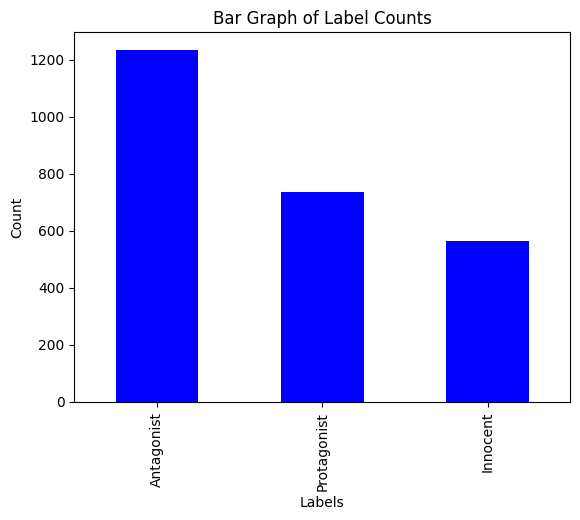

In [9]:
import matplotlib.pyplot as plt
label_counts = df['class1'].value_counts()
print(label_counts)
label_counts.plot(kind='bar', color='blue')
plt.xlabel('Labels',)
plt.ylabel('Count')
plt.title('Bar Graph of Label Counts')

#### The dataset contains 4(5 later) languages. Let's se the distribution of labels in each category.
#### Also we will view how much data we have representing every language.
Firstly data entries per languge.

lang
BG    448
Name: count, dtype: int64 lang
EN    414
Name: count, dtype: int64 lang
HI    928
Name: count, dtype: int64 lang
PT    745
Name: count, dtype: int64


<BarContainer object of 4 artists>

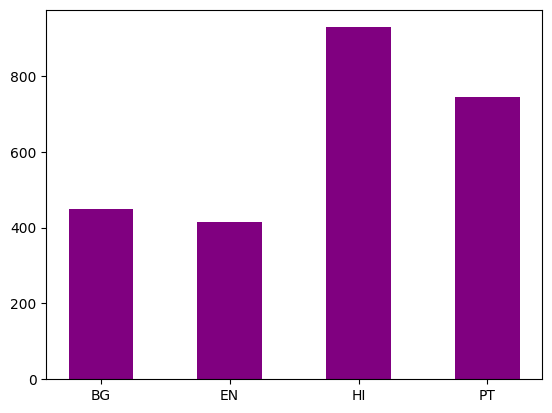

In [10]:
df_bg = df[ df['lang'] == 'BG']
df_en = df[ df['lang'] == 'EN']
df_hi = df[ df['lang'] == 'HI']
df_pt = df[ df['lang'] == 'PT']
x = ["BG", "EN", "HI", "PT"]
y = [len(df_bg), len(df_en), len(df_hi), len(df_pt)]
print(df_bg['lang'].value_counts(),
df_en['lang'].value_counts(),
df_hi['lang'].value_counts(),
df_pt['lang'].value_counts())
plt.bar(x, y, width=0.5, color='purple')

## Labels per country and category

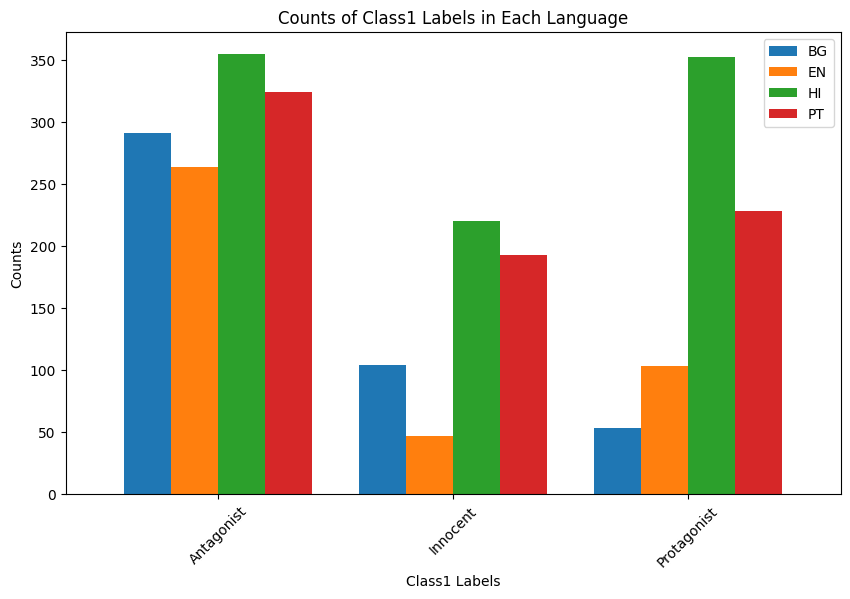

In [11]:
count_bg = df_bg['class1'].value_counts()
count_en = df_en['class1'].value_counts()
count_hi = df_hi['class1'].value_counts()
count_pt = df_pt['class1'].value_counts()

counts_df = pd.DataFrame({
    'BG': count_bg,
    'EN': count_en,
    'HI': count_hi,
    'PT': count_pt
}).fillna(0)  
ax = counts_df.plot(kind='bar', width=0.8, figsize=(10, 6))

plt.xlabel('Class1 Labels')
plt.ylabel('Counts')
plt.title('Counts of Class1 Labels in Each Language')
plt.xticks(rotation=45)  

plt.show()

class1
Antagonist     0.649554
Innocent       0.232143
Protagonist    0.118304
Name: count, dtype: float64 class1
Antagonist     0.637681
Protagonist    0.248792
Innocent       0.113527
Name: count, dtype: float64 class1
Antagonist     0.382543
Protagonist    0.380388
Innocent       0.237069
Name: count, dtype: float64 class1
Antagonist     0.434899
Protagonist    0.306040
Innocent       0.259060
Name: count, dtype: float64


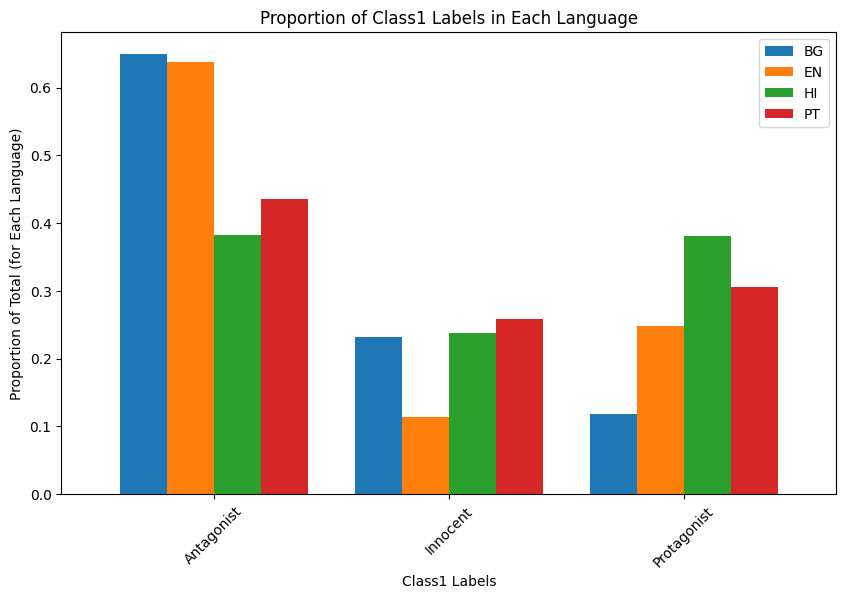

In [12]:
# Get value_counts for 'class1' in each DataFrame
count_bg = df_bg['class1'].value_counts()
count_en = df_en['class1'].value_counts()
count_hi = df_hi['class1'].value_counts()
count_pt = df_pt['class1'].value_counts()

# Calculate the total count of 'class1' for each language
total_bg = df_bg['class1'].count()
total_en = df_en['class1'].count()
total_hi = df_hi['class1'].count()
total_pt = df_pt['class1'].count()

# Calculate the proportions for each label within each language
prop_bg = count_bg / total_bg
prop_en = count_en / total_en
prop_hi = count_hi / total_hi
prop_pt = count_pt / total_pt

print(prop_bg,prop_en,prop_hi,prop_pt)
# Create a DataFrame to hold the proportions for each language
prop_df = pd.DataFrame({
    'BG': prop_bg,
    'EN': prop_en,
    'HI': prop_hi,
    'PT': prop_pt
}).fillna(0)  # Fill NaN with 0s for missing categories

# Plotting the bar plot
ax = prop_df.plot(kind='bar', width=0.8, figsize=(10, 6))

# Add labels and title
plt.xlabel('Class1 Labels')
plt.ylabel('Proportion of Total (for Each Language)')
plt.title('Proportion of Class1 Labels in Each Language')
plt.xticks(rotation=45)  # Rotate x-ticks for better visibility

# Display the plot
plt.show()

Classifying article as Russia-Ukraine war or climate change

In [13]:
import re
climate_keywords = {
    'EN': [
        "climate", "change", "warming", "carbon", "emissions", "greenhouse", "fossil", "pollution", 
        "sustainability", "deforestation", "climate justice", "activism", "accountability", "policy", 
        "impact", "reduction", "environment", "environmental", "clean energy", "renewable", "global warming", 
        "paris agreement", "cop", "activists", "debate", "responsibility", "government", "inaction", 
        "failure", "protest", "lobby", "oil", "gas", "corporations", "proposals", "green energy", 
        "eco-friendly", "transition", "scandal", "neglect", "exploitation", "polluters", "reform", 
        "carbon tax", "carbon footprint", "climate refugees", "greenwash"
    ],
    'PT': [
        "clima", "mudança", "aquecimento", "carbono", "emissões", "gases", "fósseis", "poluição", 
        "sustentabilidade", "desmatamento", "justiça climática", "ativismo", "responsabilidade", "política", 
        "impacto", "redução", "ambiente", "ambiental", "energia limpa", "renovável", "aquecimento global", 
        "acordo de paris", "cop", "ativistas", "debate", "responsabilidade", "governo", "falta de ação", 
        "fracasso", "protesto", "lobby", "petróleo", "gás", "corporações", "propostas", "energia verde", 
        "eco-friendly", "transição", "escândalo", "negligência", "exploração", "poluidores", "reforma", 
        "imposto sobre carbono", "pegada de carbono", "refugiados climáticos", "greenwash"
    ],
    'HI': [
        "जलवायु", "परिवर्तन", "तापन", "कार्बन", "उत्सर्जन", "गैस", "जीवाश्म", "प्रदूषण", 
        "सततता", "वनस्पति नाश", "जलवायु न्याय", "आंदोलन", "जिम्मेदारी", "नीति", 
        "प्रभाव", "कमी", "पर्यावरण", "पर्यावरणीय", "स्वच्छ ऊर्जा", "नवीकरणीय", "वैश्विक तापन", 
        "पेरिस समझौता", "सीओपी", "कार्यकर्ता", "बहस", "जिम्मेदारी", "सरकार", "क्रियाविहीनता", 
        "विफलता", "प्रदर्शन", "लॉबी", "तेल", "गैस", "संगठनों", "प्रस्ताव", "हरित ऊर्जा", 
        "इको-फ्रेंडली", "संक्रमण", "घोटाला", "लापरवाही", "शोषण", "प्रदूषणकर्ता", "सुधार", 
        "कार्बन कर", "कार्बन पदचिह्न", "जलवायु शरणार्थी", "ग्रीनवाश"
    ],
    'BG': [
        "климат", "промяна", "затопляне", "въглерод", "емисии", "гази", "изкопаеми", "замърсяване", 
        "устойчивост", "изсичане на гори", "климатични права", "активизъм", "отговорност", "политика", 
        "въздействие", "намаляване", "околната среда", "екологичен", "чиста енергия", "възобновяеми", 
        "глобално затопляне", "парижко споразумение", "коп", "активисти", "дебат", "отговорност", 
        "правителство", "бездействие", "неуспех", "протест", "лобизъм", "нефт", "газ", "корпорации", 
        "предложения", "зелена енергия", "екологичен", "преход", "скандал", "пренебрежение", "експлоатация", 
        "замърсители", "реформа", "данък върху въглерод", "въглероден отпечатък", "климатични бежанци", "гринуош"
    ]
}

war_keywords = {
    'EN': [
        "russia", "ukraine", "war", "invasion", "conflict", "putin", "zelensky", 
        "nato", "donbas", "crimea", "sanctions", "military", "refugees", 
        "ceasefire", "frontline", "troops", "resistance", "bombing", 
        "artillery", "territory", "proxy", "east", "donetsk", 
        "luhansk", "kyiv", "mariupol", "offensive", "battle", "strategy", 
        "counteroffensive", "occupation", "defense", "peace", "forces", 
        "army", "airstrike", "aid", "crimes", "skirmishes", 
        "battlefield", "separatists", "allies", "supply", "defense", 
        "shelters", "peacekeeping", "crisis", "drills"
    ],
    'PT': [
        "rússia", "ucrânia", "guerra", "invasão", "conflito", "putin", "zelensky", 
        "otan", "donbas", "crimeia", "sanções", "militar", "refugiados", 
        "cessar-fogo", "frente", "tropas", "resistência", "bombardeio", 
        "artilharia", "територия", "procurador", "leste", "donetsk", 
        "lugansk", "kiev", "mariupol", "ofensiva", "batalha", "estratégia", 
        "contraofensiva", "ocupação", "defesa", "paz", "forças", 
        "exército", "ataque", "ajuda", "crimes", "escaramuças", 
        "campo", "separatistas", "aliados", "fornecimento", "defesa", 
        "abrigo", "manutenção", "crise", "exercícios"
    ],
    'HI': [
        "रूस", "यूक्रेन", "युद्ध", "आक्रमण", "संघर्ष", "पुतिन", "जेलेंस्की", 
        "नाटो", "डोनबास", "क्रीमिया", "प्रतिबंध", "सैन्य", "शरणार्थी", 
        "युद्धविराम", "अग्रिम", "सैन्य", "प्रतिकार", "बमबारी", 
        "तोपख़ाना", "क्षेत्र", "प्रॉक्सी", "पूर्व", "डोनेट्स्क", 
        "लुहान्स्क", "कीव", "मारियुपोल", "आक्रमण", "युद्ध", "रणनीति", 
        "काउंटरऑफेंसिव", "आधिपत्य", "रक्षा", "शांति", "बल", 
        "सेना", "एयरस्ट्राइक", "सैन्य", "अपराध", "झड़प", 
        "युद्धक्षेत्र", "विभाजनकारी", "सहयोगी", "सप्लाई", "रक्षा", 
        "शेल्टर", "शांति", "संकट", "अभ्यास"
    ],
    'BG': [
        "русия", "украйна", "война", "нападение", "конфликт", "путин", "зелински", 
        "нато", "донбас", "крим", "санкции", "военен", "бежанци", 
        "прекратяване", "фронт", "войски", "съпротива", "бомбардировки", 
        "артилерия", "територия", "прокси", "изток", "донецк", 
        "луганск", "киев", "мариупол", "офанзива", "битка", "стратегия", 
        "контраофанзива", "окупация", "отбрана", "мир", "сили", 
        "армия", "въздушен", "помощ", "престъпления", "сблъсъци", 
        "бойно", "сепаратисти", "съюзници", "доставки", "отбрана", 
        "укрития", "миротворчество", "криза", "упражнения"
    ]
}
def determineType(row):
    text = str(row['text'])
    text = text.lower().strip().replace('\n','')
    clean_text = re.sub(r'[^\w\s]', '', text)
    cc, ru = 0, 0
    
    for z in text.split(' '):
        if z in climate_keywords[row['lang']]:
            cc+=1
        if z in war_keywords[row['lang']]:
            ru+=1
    if cc > 0 and ru == 0:
        return "Climate change"
    elif cc == 0 and ru > 0:
        return "War"
    elif cc == 0 and ru == 0:
        return "None error"
    elif cc > 0 and ru > 0:
        return "Inconclusive error"

df['artCat'] = df.apply(determineType,axis=1)


artCat
Inconclusive error    1469
War                    929
Climate change         128
None error               9
Name: count, dtype: int64


Text(0.5, 1.0, 'Bar Graph of Label Counts')

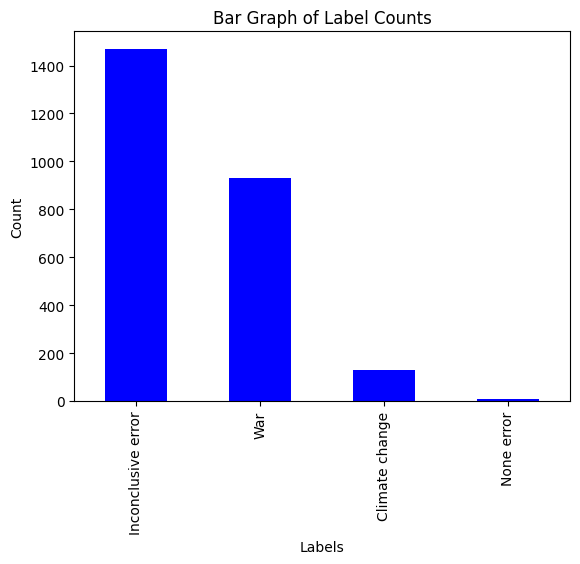

In [14]:
df.aggregate
label_counts = df['artCat'].value_counts()
print(label_counts)
label_counts.plot(kind='bar', color='blue')
plt.xlabel('Labels',)
plt.ylabel('Count')
plt.title('Bar Graph of Label Counts')

## Analysis of distance between spans in the same text

### Analysis for EN
Here is a short analysis of size of the input text, number of spans per text, as well as distance between spans in the same text.

In [28]:
df_en["start"] = df_en["start"].astype(int)
df_en["end"] = df_en["end"].astype(int)
df_en_spanEDA = df_en.sort_values(by=["art_name", "start"])

df_en_spanEDA['inter_span_distance'] = df_en_spanEDA.groupby('art_name')['start'].shift(0) - df_en_spanEDA.groupby('art_name')['end'].shift(1)

summary = df_en_spanEDA.groupby('art_name').agg(
    min_distance=('inter_span_distance', 'min'),
    max_distance=('inter_span_distance', 'max'),
    mean_distance=('inter_span_distance', 'mean'),
    stddev_distance=('inter_span_distance', 'std'),
    text_length=('text', lambda x: len(x.iloc[0])),
    span_count=('start', 'size')
).reset_index()

print(summary)
print("Mean of number of spans per text: ", summary["span_count"].mean())
print("Median of number of spans per text: ", summary["span_count"].median())

print("Mean of distances in all texts (ignoring span_count=1): ", summary["mean_distance"].mean())


             art_name  min_distance  max_distance  mean_distance  \
0    EN_CC_100002.txt           NaN           NaN            NaN   
1    EN_CC_100003.txt         905.0         905.0          905.0   
2    EN_CC_100004.txt         231.0        2146.0         1188.5   
3    EN_CC_100005.txt        1941.0        1941.0         1941.0   
4    EN_CC_100012.txt         439.0        1282.0          853.0   
..                ...           ...           ...            ...   
101  EN_UA_103995.txt        2207.0        2207.0         2207.0   
102  EN_UA_104434.txt           NaN           NaN            NaN   
103  EN_UA_104523.txt           NaN           NaN            NaN   
104  EN_UA_104859.txt         282.0         282.0          282.0   
105  EN_UA_104876.txt        2202.0        2202.0         2202.0   

     stddev_distance  text_length  span_count  
0                NaN         2800           1  
1                NaN         2396           2  
2        1354.109486         4346      

C:\Users\cvita\AppData\Local\Temp\ipykernel_10116\3802205066.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en["start"] = df_en["start"].astype(int)
C:\Users\cvita\AppData\Local\Temp\ipykernel_10116\3802205066.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en["end"] = df_en["end"].astype(int)


### Analysis for all languages - Merged data

In [ ]:
df["start"] = df["start"].astype(int)
df["end"] = df["end"].astype(int)
df_spanDA = df.sort_values(by=["art_name", "lang", "start"])

df_spanDA['inter_span_distance'] = df_spanDA.groupby('art_name')['start'].shift(0) - df_spanDA.groupby('art_name')['end'].shift(1)

summary = df_spanDA.groupby('art_name', 'lang').agg(
    min_distance=('inter_span_distance', 'min'),
    max_distance=('inter_span_distance', 'max'),
    mean_distance=('inter_span_distance', 'mean'),
    stddev_distance=('inter_span_distance', 'std'),
    text_length=('text', lambda x: len(x.iloc[0])),
    span_count=('start', 'size')
).reset_index()

print(summary)
print("Mean of number of spans per text (EN): ", summary.loc[summary["lang"] == "EN", "mean_distance"].mean())
print("Mean of number of spans per text (BG): ", summary.loc[summary["lang"] == "BG", "mean_distance"].mean())
print("Mean of number of spans per text (PT): ", summary.loc[summary["lang"] == "PT", "mean_distance"].mean())
print("Mean of number of spans per text (HI): ", summary.loc[summary["lang"] == "HI", "mean_distance"].mean())

print("Mean of distances in all texts (ignoring span_count=1): ", summary["mean_distance"].mean())


ValueError: No axis named lang for object type DataFrame